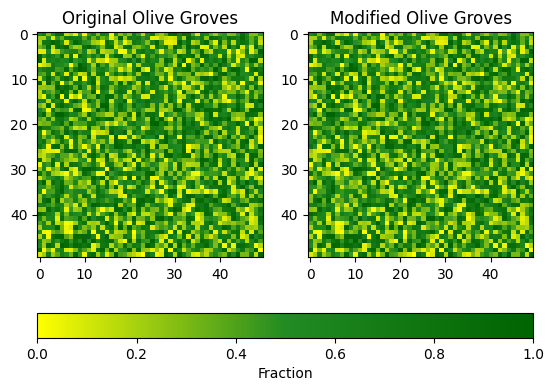

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp

np.random.seed(3)

# Load data from url: https://github.com/drsmwhite/Xylella-spread-model/tree/master
mat = sp.io.loadmat("olivegrowthprop.mat")
# olive_prop = mat["olivegrowthprop"] # Phi
H = 50
W = 50
olive_prop = np.random.random([H,W])
# H, W = olive_prop.shape # M, N
# print(f"Height: {H}, Width: {W}")

# Plot distribution of olive groves
fig, ax = plt.subplots(1, 2)
cmap_custom = colors.LinearSegmentedColormap.from_list("", ["yellow", "forestgreen", "darkgreen"]) # matplotlib.cm.YlGn
cmap_custom.set_under("tab:blue")
norm = colors.Normalize(vmin=0, vmax=1)
images = []

images.append(ax[0].imshow(olive_prop, cmap=cmap_custom))
ax[0].set_title("Original Olive Groves")

# olive_prop[olive_prop >= 0] = 0.9
images.append(ax[1].imshow(olive_prop, cmap=cmap_custom))
ax[1].set_title("Modified Olive Groves")

for im in images:
    im.set_norm(norm)

cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal", fraction=0.1)
cbar.set_label("Fraction")

plt.show()

In [151]:
# # Remove all trees in the buffer zone
# xp1, yp1 = [253, 212]
# xp2, yp2 = [278, 183]

# BW1 = 2 # bufferwidth1 eradication zone width
# BW2 = 13 # bufferwidth2 buffer zone width
# eff = 0.9 # eff control efficiency in the buffer zone
# timerun = 8 # how many years does the model run for?

# m = (yp1 - yp2) / (xp1 - xp2)
# B1 = yp1 - m * xp1
# B2_erad = B1 - BW1 * np.sqrt(m**2 + 1)
# B2_rog = B1 - (BW1 + BW2) * np.sqrt(m**2 + 1)

# for x in range(W):
#     for y in range(H):
#         if y < m*x+B1 and y > m*x+B2_erad and olive_prop[y,x] > 0:
#             olive_prop[y,x] = 0

# ax.plot((xp1, xp2), (yp1, yp2), 'ro-', linewidth=1) # infection line

# x_erad1 = xp1 - 2
# x_erad2 = xp2 - 4
# y_erad1 = A1 * x_erad1 + B2_erad
# y_erad2 = A1 * x_erad2 + B2_erad
# ax.plot((x_erad1, x_erad2), (y_erad1, y_erad2), 'bo-', linewidth=1) # eradication line (eradication zone limit)

# x_rog1 = xp1 - 5
# x_rog2 = xp2 - 9
# y_rog1 = A1 * x_rog1 + B2_rog
# y_rog2 = A1 * x_rog2 + B2_rog
# ax.plot((x_rog1, x_rog2), (y_rog1, y_rog2), 'bo-', linewidth=1) # roguing line (buffer zone limit)

# plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


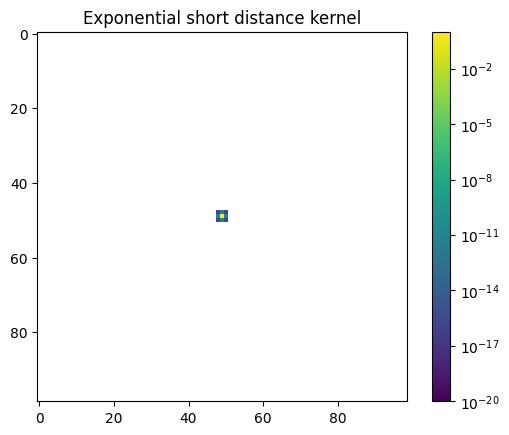

In [163]:
# Short distance kernel
beta = 0.05 # mean dispersal distance
# x2, y2 = np.meshgrid(np.arange(W), np.arange(H))

def exponential_kernel(x, y):
    global beta
    return np.exp(-(x**2 + y**2)**(1/2) / beta) #/ (2 * np.pi * beta**2)

def gaussian_kernel(x, y):
    global beta
    return np.exp(-(x**2 + y**2)/(2 * beta**2)) / np.sqrt(2 * np.pi * beta**2)

x = np.linspace(-(W-1), (W-1), 2*W-1)
y = np.linspace(-(H-1), (H-1), 2*H-1)

X, Y = np.meshgrid(x, y)
k = exponential_kernel(X,Y) # No need to normalize: grid widths are 1x1 so sum over w * grid = w * 1
# k = gaussian_kernel(X,Y)
print(k)

k_min = np.min(k)
k_min = 1e-20
fig, ax = plt.subplots()
im = ax.imshow(k, norm=colors.LogNorm(vmin=k_min, vmax=1))
ax.set_title("Exponential short distance kernel")
# ax.set_title("Gaussian short distance kernel")
fig.colorbar(im, ax=ax)
plt.show()

In [164]:
def zero_threshold(array):
    array[array < 0] = 0
    return array

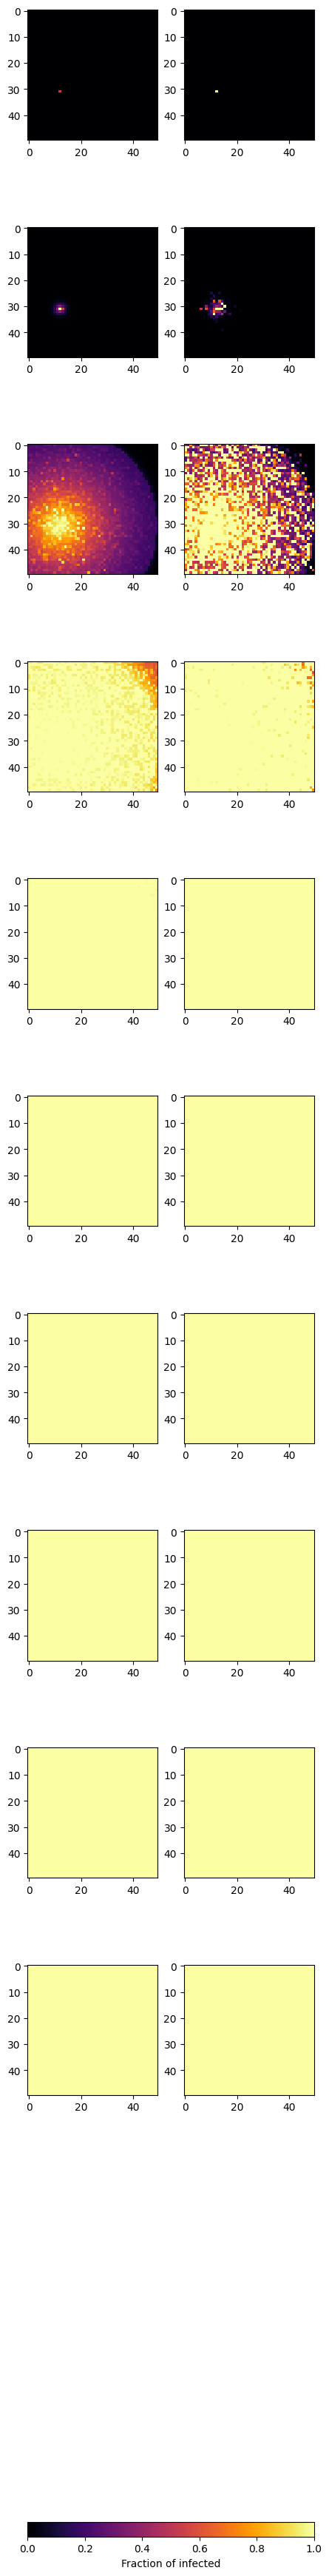

In [165]:
np.random.seed(20392)

# Gompertz model parameters
A = 3 # 3 kp rate of population growth
B = 14.069

# Carrying capacity
a = 0 # relative carrying capacity in non olive plants
K = olive_prop + a * (1 - olive_prop) # CC carrying capacity
K[olive_prop < 0] = 0
tol = 10^-8 # numerical noise tolerance

# # Long distance kernel
# p = 0.2 # strattol stratified dispersal tolerance (threshold probability)
# M_max = 5 # maximum number of dispersers
# D = 20 # dispersal standard deviation

# SIMULATE DIFFUSION
time_steps = 10
U = np.zeros((time_steps+1, H, W)) # Fraction of infected

seed = np.random.randint(0,[H,W]) # seed somewhere where olive_prop > 0 (otherwise also K is 0)
U[0, seed[0], seed[1]] = K[seed[0], seed[1]] * np.exp(-B) # initial outbreak
P = U
P[0] = U[0] / olive_prop

width = 5
fig, ax = plt.subplots(time_steps, 2, figsize=(width, width*time_steps))
images = []

logNorm = colors.LogNorm(vmin=1e-60, vmax=1)
norm = colors.Normalize(vmin=0, vmax=1)

for t in range(time_steps):
    # print(f"Timestep {t}")
    U[t+1] = K ** (1 - np.exp(-A)) * (U[t] ** np.exp(-A)) # local growth
    P[t+1] = U[t+1] / olive_prop
    # print(f"Local growth:\n{U[t+1]}")
    images.append(ax[t,0].imshow(P[t+1], cmap="inferno"))

    U[t+1] = sp.signal.convolve(U[t+1], k, mode="same", method="direct")
    # print(f"Short distance:\n{U[t+1]}")
    U[t+1] = zero_threshold(U[t+1])
    P[t+1] = U[t+1] / olive_prop
    images.append(ax[t,1].imshow(P[t+1], cmap="inferno"))

for im in images:
    im.set_norm(norm)

cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal", fraction=0.1)
cbar.set_label("Fraction of infected")

plt.show()

In [144]:
print(K[seed[0], seed[1]], U[0, seed[0], seed[1]])
U[0, seed[0], seed[1]] = K[seed[0], seed[1]] ** (1 - np.exp(-A)) * (U[0, seed[0], seed[1]] ** np.exp(-A))
print(K[seed[0], seed[1]] ** (1 - np.exp(-A)))
print(U[0, seed[0], seed[1]] ** np.exp(-A))
print(U[0, seed[0], seed[1]])

0.5908628174163508 0.5898378204368405
0.6065458983258025
0.9741394280843909
0.5908117437144792


In [127]:
# # print(np.where(olive_prop < 0)) # collect all coordinates where olive_prop < 0: disease seed has to be inside the region, not in the sea. TODO
# # seed = np.array([235, 266]) # initial outbreak near Gallipoli

# print(U[1,:,:])

# U[2,:,:] = K ** (1 - np.exp(-A)) * (U[1,:,:] ** np.exp(-A))
# print(U[2,:,:])
# U[2,:,:] = sp.signal.fftconvolve(U[1,:,:], w, mode="same")

# fig, ax = plt.subplots()
# im = ax.imshow(U[0,:,:], cmap=cmap_custom, vmin=0, vmax=1)
# fig.colorbar(im)
# plt.show()

# for t in range(time_steps): # evolution
#     # Local population growth
#     U[t+1,:,:] = K ** (1 - np.exp(-A)) * (U[t,:,:] ** np.exp(-A))
    
#     print(U[t+1,:,:].shape)

#     # Short distance dispersal
#     U[t+1,:,:] = sp.signal.fftconvolve(U[t+1,:,:], w, mode="same")
#     # print(U[t+1,:,:])
#     # print(t)
#     # # if t % 10 == 0:
#     fig, ax = plt.subplots()
#     im = ax.imshow(U[t+1,:,:], cmap=cmap_custom, vmin=0, vmax=1)
#     fig.colorbar(im)
#     # plt.show()
#     # Long distance dispersal


# # # d = np.random.exponential(beta) # generate random distance according to short-distance dispersal kernel
# # # theta = np.random.random()*2*np.pi # generate random dispersal angle
# # # x = d * np.cos(theta)
# # # y = d * np.sin(theta)
# # # check that the dispersal doesn't go into the sea TODO

# # # Long distance dispersal TODO

In [128]:
np.allclose(U[0,:,:], U[1,:,:], rtol=1e-10)

False

In [129]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd

data2022 = pd.read_csv("Data/CAMP_2022.csv", encoding='latin-1') # , skiprows=
# pd.DataFrame(pd.read_excel("Data/CAMP_2022.xlsx"))

# read_file = pd.read_excel("Data/CAMP_2022.xlsx") 
# read_file.to_csv ("Data/CAMP_2022.csv",
#                   index = None, 
#                   header=True) 
# data2022 = pd.DataFrame(pd.read_csv("Data/CAMP_2022.csv")) 

display(data2022.head())

# Extract latitude and longitude
latitudes = data2022["LATITUDINE"].values
longitudes = data2022["LONGITUDINE"].values


,ID,DATA_RILEVAMENTO,TIPOLOGIA,SPECIE,CULTIVAR,SINTOMO,LATITUDINE,LONGITUDINE,COMUNE,RISULTATO
0,1320420,22/06/2022,Campione,Olivo (Olea europaea),Cima di Mola,Assente,41.000950,17.174447,Polignano a Mare,Negativo
1,1320749,22/06/2022,Campione,Olivo (Olea europaea),Altro,Assente,41.000285,17.176400,Polignano a Mare,Negativo
2,1321226,22/06/2022,Campione,Olivo (Olea europaea),Cima di Mola,Assente,40.999828,17.174302,Polignano a Mare,Negativo
3,1321444,22/06/2022,Campione,Olivo (Olea europaea),Cima di Mola,Assente,41.001559,17.175157,Polignano a Mare,Negativo
4,1320518,22/06/2022,Campione,Olivo (Olea europaea),Altro,Assente,40.868763,17.384971,Fasano,Negativo


In [130]:
# TODO: gather all datas from yearly monitoring campaigns and do timeseries/animation of yearly advancement. 
# Just plot to see if there are holes in the continuation of the disease or if we are able to make an accurate map of the evolution

# # Create a figure and a basemap
# # lower_left = [40.5, 16.8]
# # upper_right = [41.0, 17.5]

# plt.figure(figsize=(10, 10))
# m = Basemap(projection='merc',
#             llcrnrlat=min(latitudes)-0.1, urcrnrlat=max(latitudes)+0.1,
#             llcrnrlon=min(longitudes)-0.1, urcrnrlon=max(longitudes)+0.1,
#             resolution='i') # c (crude), l (low), i (intermediate), h (high), f (full)

# # Draw coastlines and countries for context
# m.drawcoastlines()
# m.drawcountries()

# # Convert lat/long to map projection coordinates
# x, y = m(longitudes, latitudes)

# # Plot the points
# m.scatter(x, y, marker='o', color='red', s=0.1)

# # Title and show the plot
# plt.title('Tree Locations on Basemap')
# plt.show()
